<a href="https://colab.research.google.com/github/Fernanda-85/MVP_Machine-Learning/blob/main/mvp_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Machine Learning & Analytics
**Nome:** Fernanda Figueira

**Matrícula:** 405202400226633

**Dataset:** Consumo de café e qualidade do sono

**Fonte:** Kaggle

### - Projeto de Machine Learning
### - Problema de classificação
### - Objetivo: Prever a qualidade do sono dos indivíduos de acordo com as variáveis de consumo de café/cafeína.
### - Área de aplicação: Saúde
### - Valor para usuário: melhorar a qualidade do sono controlando a ingestão de cafeína.

## 2. Reprodutibilidade e ambiente

### Dataset escolhido:
https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset/data

Arquivo baixado: synthetic_coffee_health_10000.csv


### Bibliotecas importadas:

In [256]:
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## 3. Dados: carga, entendimento e qualidade

### Carregando o dataset:

In [262]:

# Link bruto do arquivo CSV no GitHub
url = "https://raw.githubusercontent.com/Fernanda-85/MVP_Machine-Learning/main/synthetic_coffee_health_10000.csv"

# Ler o arquivo
df = pd.read_csv(url)

# Visualizar as primeiras linhas
df.head()



,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

##3.1 Análise exploratória resumida (EDA)

In [259]:
fig = px.histogram(df, x='Sleep_Quality', title='Distribuição das Classes de Qualidade do Sono',
      labels={'Sleep_Quality': 'Qualidade do Sono'}, color='Sleep_Quality')
fig.show()

#### - Observamos um desbalanceamento de classes, visto que a classe "Good" é muito superior às demais.

## 4.1 Pré-processamento realizado para ajustar parâmetros

In [263]:
# Remover colunas irrelevantes
df.drop(columns=["ID", "Country"], inplace=True)

# Remover linhas com valores nulos na variável alvo
df = df.dropna(subset=["Sleep_Quality"])

# Preencher valores nulos em outras colunas com a mediana (numéricas) ou modo (categóricas)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

In [264]:
# Verificar a distribuição da variável alvo 'Sleep Quality'
sleep_quality_counts = df['Sleep_Quality'].value_counts()
print(sleep_quality_counts)

Sleep_Quality
Good         5637
Fair         2050
Excellent    1352
Poor          961
Name: count, dtype: int64


In [265]:
# Preparar os dados para balanceamento
X = df.drop(columns=['Sleep_Quality'])
y = df['Sleep_Quality']

# Codificar variáveis categóricas
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=["object"]).columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Combinar os dados balanceados em um novo DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X_encoded.columns)
df_resampled["Sleep_Quality"] = y_resampled
df_resampled



,Age,Gender,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption,Sleep_Quality
0,40,1,3.5,328.100000,7.500000,24.900000,78,1,14.500000,0,2,0,0,Good
1,33,1,1.0,94.100000,6.200000,20.000000,67,1,11.000000,0,3,0,0,Good
2,42,1,5.3,503.700000,5.900000,22.700000,59,2,11.200000,0,1,0,0,Fair
3,53,1,2.6,249.200000,7.300000,24.700000,71,1,6.600000,0,2,0,0,Good
4,32,0,3.1,298.000000,5.300000,24.100000,76,2,8.500000,0,4,0,1,Fair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22543,35,0,1.9,177.352495,4.894001,24.917998,68,0,2.392501,0,3,1,0,Poor
22544,28,1,1.2,116.148330,4.144990,15.876620,61,0,2.951080,0,3,0,0,Poor
22545,18,1,5.0,471.802791,4.400000,18.130303,80,0,13.799203,0,0,0,0,Poor
22546,30,0,0.0,0.246000,4.090000,24.106001,74,0,10.346002,0,1,0,1,Poor


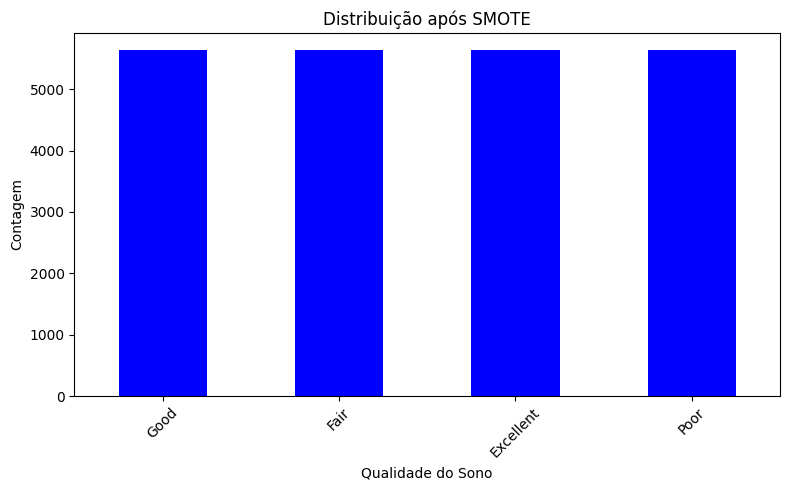

In [267]:
# Visualizar distribuição após SMOTE
plt.figure(figsize=(8, 5))
pd.Series(y_resampled).value_counts().plot(kind='bar', color='blue')
plt.title('Distribuição após SMOTE')
plt.xlabel('Qualidade do Sono')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [268]:
# Verificar a distribuição da variável alvo 'Sleep Quality' após balanceamento
sleep_quality_counts = df_resampled['Sleep_Quality'].value_counts()
print(sleep_quality_counts)

Sleep_Quality
Good         5637
Fair         5637
Excellent    5637
Poor         5637
Name: count, dtype: int64


In [269]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22548 entries, 0 to 22547
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      22548 non-null  int64  
 1   Gender                   22548 non-null  int64  
 2   Coffee_Intake            22548 non-null  float64
 3   Caffeine_mg              22548 non-null  float64
 4   Sleep_Hours              22548 non-null  float64
 5   BMI                      22548 non-null  float64
 6   Heart_Rate               22548 non-null  int64  
 7   Stress_Level             22548 non-null  int64  
 8   Physical_Activity_Hours  22548 non-null  float64
 9   Health_Issues            22548 non-null  int64  
 10  Occupation               22548 non-null  int64  
 11  Smoking                  22548 non-null  int64  
 12  Alcohol_Consumption      22548 non-null  int64  
 13  Sleep_Quality            22548 non-null  object 
dtypes: float64(5), int64(8

## 4. Definição do target, variáveis e divisão dos dados

In [270]:
# Codificar variáveis categóricas
label_cols = df_resampled.select_dtypes(include="object").columns
le = LabelEncoder()
for col in label_cols:
    df_resampled[col] = le.fit_transform(df_resampled[col])


# Separar variáveis independentes e alvo
X = df_resampled.drop(columns=['Coffee_Intake', 'Caffeine_mg'])
y = df_resampled["Sleep_Quality"]

# Normalizar variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Conferindo as colunas e os tipos de instâncias após ajustes

In [271]:
print(f"Total de instâncias: {len(df_resampled)}")
print("\nTipos de dados por coluna:")
df_resampled.info()

Total de instâncias: 22548

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22548 entries, 0 to 22547
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      22548 non-null  int64  
 1   Gender                   22548 non-null  int64  
 2   Coffee_Intake            22548 non-null  float64
 3   Caffeine_mg              22548 non-null  float64
 4   Sleep_Hours              22548 non-null  float64
 5   BMI                      22548 non-null  float64
 6   Heart_Rate               22548 non-null  int64  
 7   Stress_Level             22548 non-null  int64  
 8   Physical_Activity_Hours  22548 non-null  float64
 9   Health_Issues            22548 non-null  int64  
 10  Occupation               22548 non-null  int64  
 11  Smoking                  22548 non-null  int64  
 12  Alcohol_Consumption      22548 non-null  int64  
 13  Sleep_Quality        

## 5. Tratamento de dados e Pipeline de pré-processamento

## Separação em conjuntos de treino e testes e realização de Validação Cruzada

In [275]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 42 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_resampled.values
X = array[:, 0:13]
y = array [:,13]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
test_size=test_size, shuffle = True, random_state=seed, stratify=y)

#Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação



## Lista de modelos de algoritmo de classificação e parametrização para aplicação de modelos a ensambles:


In [282]:
np.random.seed(seed) #definindo uma semente global
num_trees = 100
max_features = 3

# Lista que armazenará os modelos
models = []

# Criando modelos e adicionando na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('CART', DecisionTreeClassifier()))

## Ensambles e comparação de modelos

LR: 1.000000 (0.000000)
CART: 1.000000 (0.000000)
RF: 1.000000 (0.000000)
ET: 1.000000 (0.000000)


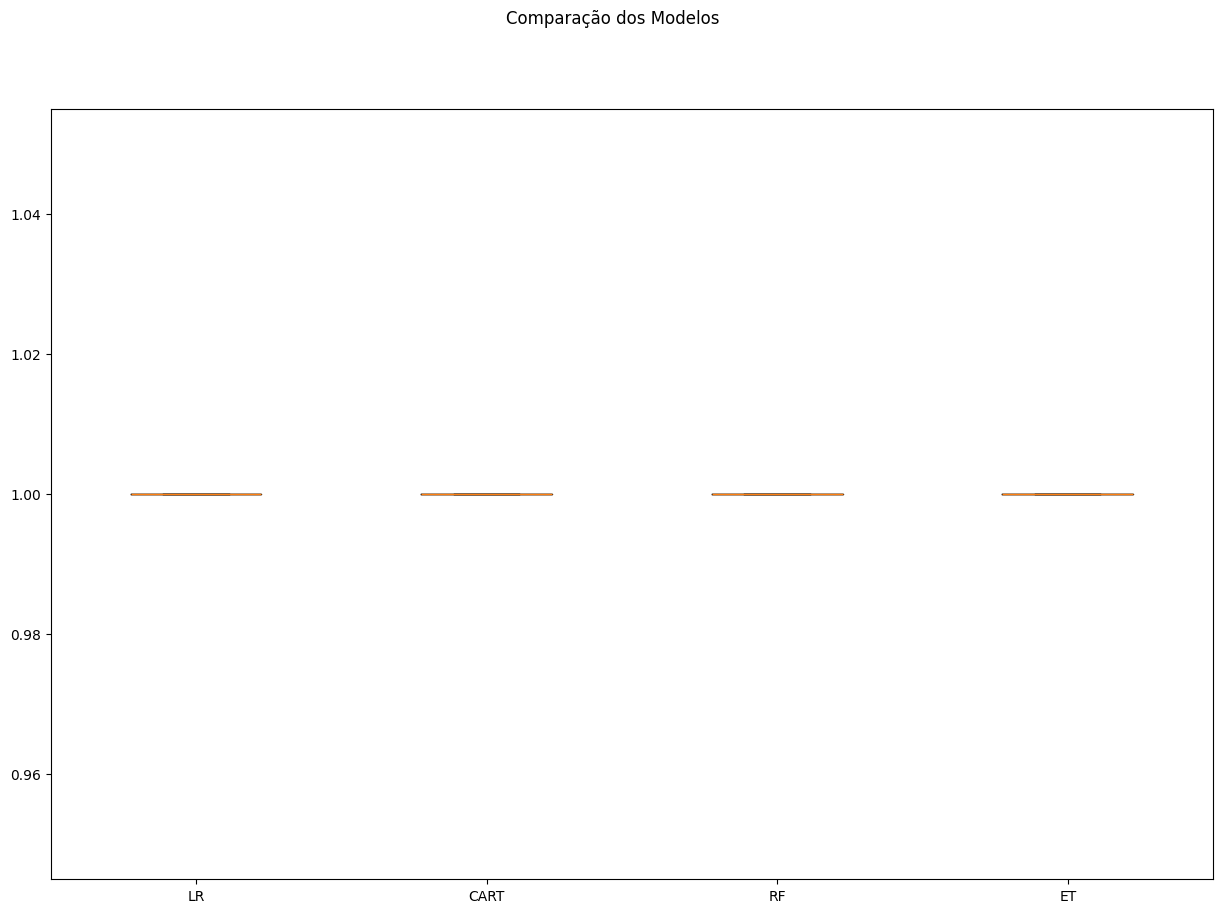

In [277]:
# Criando ensembles e adicionando na lista de modelos
models.append(('RF', RandomForestClassifier(n_estimators= num_trees, max_features= max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators= num_trees, max_features= max_features)))

# Lista para armazenar os resultados
results = []
names = []

#Avaliação dos modelos
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

#Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



#Modelo escolhido: CART - Alta acurária e boa estabilidade, tendo em vista o baixo valor de desvio padrão.

In [278]:
#Avaliação do modelo com o conjunto de testes

#Preparação do modelo
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model =  DecisionTreeClassifier()
model.fit(rescaledX, y_train)

#Estimativa de acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))



1.0


In [279]:
#Preparação do modelo como todo o dataset
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
model.fit(rescaledX, y)

DecisionTreeClassifier()

In [280]:
# Novos dados - não sabemos a classe!
data = {'Coffee_Intake': [90, 7, 6, 20],
        'Caffeine_mg': [2000, 307.2, 125.8, 950.0],
        'Sleep_Hours': [8.8, 6.9, 7.0, 4.1],
        'Age': [22, 19, 52, 68],
        'Gender':[1, 0, 1, 0],
        'BMI': [23.9, 25.1, 24.2, 34.6],
        'Heart_Rate':	[68, 72, 77, 95],
        'Stress_Level': [0, 1, 1, 3],
        'Physical_Activity_Hours': [18, 16, 15, 5],
        'Health_Issues': [0, 0, 0, 1],
        'Occupation': [1, 4, 3, 4],
        'Smoking': [0, 0, 0, 1],
        'Alcohol_Consumption': [0, 0, 1, 1]
        }

atributos = ['Coffee_Intake',	'Caffeine_mg', 'Sleep_Hours', 'Age', 'Gender',	'BMI',	'Heart_Rate',	'Stress_Level',
             'Physical_Activity_Hours',	'Health_Issues',	'Occupation',	'Smoking',	'Alcohol_Consumption']
entrada = pd.DataFrame (data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:13].astype(float)

#Padronização nos dados de entrada ussando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)




[[ 5.16428975e+00  3.94765681e+03  4.22511692e+00 -1.57684806e+00
  -3.36515280e+00 -3.58961596e-02 -2.50255298e-01 -1.41421356e+00
   2.60916544e+00 -2.10119376e-01 -5.93823564e-01 -3.51220613e-01
  -4.64741292e-01]
 [-2.57884320e+00  6.05723581e+02  2.93861927e+00 -1.59823084e+00
  -3.99007309e+00  3.02343255e-01  1.76660265e-01  0.00000000e+00
   2.11284174e+00 -2.10119376e-01  1.75233619e+00 -3.51220613e-01
  -4.64741292e-01]
 [-2.67213396e+00  2.47602900e+02  3.00632967e+00 -1.36302031e+00
  -3.36515280e+00  4.86636940e-02  7.10304719e-01  0.00000000e+00
   1.86467989e+00 -2.10119376e-01  9.70282939e-01 -3.51220613e-01
   2.15173478e+00]
 [-1.36606334e+00  1.87474218e+03  1.04272800e+00 -1.24897884e+00
  -3.99007309e+00  2.98007195e+00  2.63142475e+00  2.82842712e+00
  -6.16938601e-01  4.57550859e+00  1.75233619e+00  2.84721330e+00
   2.15173478e+00]]


In [281]:
# Predição de classes para novos dados
saidas = model.predict(rescaledEntradaX)
print(saidas)

[3. 2. 2. 1.]
